In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    print("Agrego el src")

/home/apernin/.dev/tda_2023Q1/tp2/src
Agrego el src


In [2]:
from data import generate_random_data
from bruteforce import bruteforce, pack
from utils import perform_time_test

import matplotlib.pyplot as plt
import pandas as pd
import random
from collections.abc import Iterable
from multiprocessing import Pool

In [3]:
generate_random_data()

[0.67, 0.55, 0.09, 0.83, 0.42, 0.38, 0.61, 0.55, 0.01, 0.55]

In [4]:
def ratio_f(n, data):
    result_Z, _ = perform_time_test(bruteforce, data)
    result_A, _ = perform_time_test(pack, data)
    
    return n, len(result_A), len(result_Z), len(result_A)/len(result_Z)


def test_ratio(nsets: Iterable[float], pool_size=1):
    ns = []
    approximate_results = []
    exact_results = []
    ratio_results = []

    async_responses = []
    
    with Pool(pool_size) as p:
        for data in nsets:
            nlen = len(data)
            #print(f'Llamo con {nlen} y {data}')
            async_res = p.apply_async(ratio_f, args=(nlen, data))
            #print(f'Obtuve como resultado de {nlen} en {exe_time}')
            async_responses.append(async_res)
            #time_results.append(exe_time)
            #ns.append(nlen)

        for async_res in async_responses:
            try:
                async_res.wait()
                n, result_approx, result_exact, ratio = async_res.get()
                ns.append(n)
                approximate_results.append(result_approx)
                exact_results.append(result_exact)
                ratio_results.append(ratio)
            except KeyboardInterrupt:
                print("Exiting at client will")
                pass

    df = pd.DataFrame({'n': ns, 'approx': approximate_results, 'optimal': exact_results, 'ratio': ratio_results})
    return df

In [5]:
df_accum = None

In [6]:
%%time
min_n = 6
max_n = 10
total_tests = 1500

testdata = (generate_random_data(length=random.randint(min_n, max_n)) for i in range(total_tests))
#list(testdata)
    
df_test = test_ratio(nsets=testdata, pool_size=4)
if df_accum is None:
    df_accum = df_test
else:
    df_accum = pd.concat([df_accum, df_test])
#df_test

CPU times: user 348 ms, sys: 122 ms, total: 471 ms
Wall time: 31min 30s


In [7]:
len(df_accum)

1500

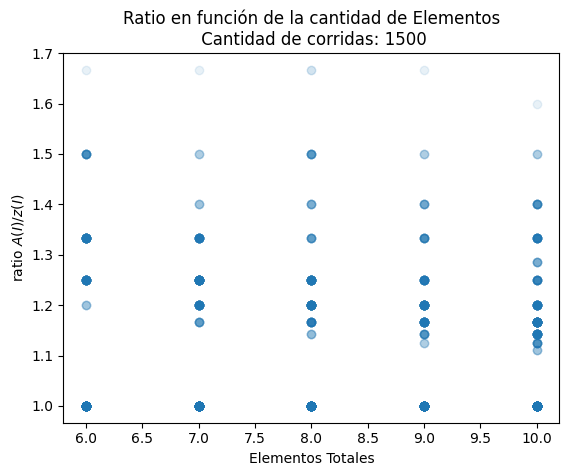

In [15]:
plt.scatter(df_accum['n'], df_accum['ratio'], alpha=0.1)
#plt.axhline(y = 2, color = 'r', linestyle = '-')
#plt.ylim(1, 2.5)
plt.xlabel("Elementos Totales")
plt.ylabel("ratio $A(I)/z(I)$")
plt.title(f"Ratio en función de la cantidad de Elementos\n Cantidad de corridas: {len(df_accum)}")
plt.show()

In [13]:
total = len(df_accum)
grouping = {
    'r==1': (df_accum['ratio'] == 1).sum(),
    '1< r <= 1.5': ((df_accum['ratio'] > 1) & (df_accum['ratio']<= 1.5)).sum(),
    '1.5 < r <= 2': ((df_accum['ratio'] > 1.5) & (df_accum['ratio'] <=2 )).sum()
}
grouping

{'r==1': 684, '1< r <= 1.5': 810, '1.5 < r <= 2': 6}

In [14]:
ratio_keys = []
ratio_counts = []
ratio_percs = []

for key, counts in grouping.items():
    ratio_keys.append(key)
    ratio_counts.append(counts)
    ratio_percs.append(counts/total)

df_ratios = pd.DataFrame({'group': ratio_keys, 'count': ratio_counts, 'perc': ratio_percs})
print(df_ratios.to_latex(index=False, column_format='|c|c|c|'))
df_ratios

\begin{tabular}{|c|c|c|}
\toprule
group & count & perc \\
\midrule
r==1 & 684 & 0.456000 \\
1< r <= 1.5 & 810 & 0.540000 \\
1.5 < r <= 2 & 6 & 0.004000 \\
\bottomrule
\end{tabular}



,group,count,perc
0,r==1,684,0.456
1,1< r <= 1.5,810,0.540
2,1.5 < r <= 2,6,0.004
